In [1]:
!pip install h5py

ERROR: ld.so: object '/usr/lib/x86_64-linux-gnu/libGLEW.so' from LD_PRELOAD cannot be preloaded (cannot open shared object file): ignored.
ERROR: ld.so: object '/usr/lib/x86_64-linux-gnu/libGLEW.so' from LD_PRELOAD cannot be preloaded (cannot open shared object file): ignored.
ERROR: ld.so: object '/usr/lib/x86_64-linux-gnu/libGLEW.so' from LD_PRELOAD cannot be preloaded (cannot open shared object file): ignored.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/Python/3.10.4-GCCcore-11.3.0/bin/python -m pip install --upgrade pip' command.


In [2]:
# import NN necessities:
import torch
from torch import nn

# import plotting utilities:
import matplotlib.pyplot as plt

# import data preprocessing utilities:
from sklearn.model_selection import train_test_split
from pathlib import Path
import h5py
import numpy as np

In [ ]:
class Network(nn.Module):   # class defining a basic nn

    def __init__(self, h_size=200):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(23, h_size),      # in
            nn.ReLU(),
            nn.Linear(h_size, h_size),    # hidden, 3 layers
            nn.ReLU(),
            nn.Linear(h_size, h_size),
            nn.ReLU(),
            nn.Linear(h_size, h_size),
            nn.ReLU(),
            # nn.Linear(h_size, 18)       # out
        )
        self.mean_head = nn.Linear(h_size, 18)
        self.logvar_head = nn.Linear(h_size, 18)

        # bind log-variance to avoid numerical instability
        self.max_logvar = nn.Parameter(torch.ones(18) * 0.5)
        self.min_logvar = nn.Parameter(torch.ones(18) * -10)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.criterion = nn.MSELoss()    # using mean squared error as a loss metric

    def forward(self, x):
        res = self.model(x)
        mean = self.mean_head(res)
        logvar = self.logvar_head(res)

        # clamp log-variance using soft constraints (see MBPO/PETS)
        logvar = self.max_logvar - torch.nn.functional.softplus(self.max_logvar - logvar)
        logvar = self.min_logvar + torch.nn.functional.softplus(logvar - self.min_logvar)
        return mean, logvar

    def nll_loss(self, x, y):
        """
        Negative log-likelihood of Gaussian:
            NLL = 0.5 * [ logσ² + (y - µ)² / σ² ]
        """
        mean, logvar = self.forward(x)
        var = torch.exp(logvar)

        nll = 0.5 * ((y - mean)**2 / var + logvar)
        return nll.mean()

    def train_epoch(self, x, y):
        self.optimizer.zero_grad()

        loss = self.nll_loss(x, y)

        loss.backward()
        self.optimizer.step()
        return loss.item()


    def train(self, train_data, epochs=500, cp=100):
        x, y = train_data

        # again split the data to optimize hyperparam on val set, not leak data.
        x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, shuffle=True)
    
        test_losses = []
        losses = []
    
        for iter in range(epochs):
            # train
            iteration_loss = self.train_epoch(x_train, y_train)
            losses.append(iteration_loss)

            # validate
            val_loss = self.validation_loss((x_val, y_val))
            test_losses.append(val_loss)
    
            # print
            if iter and iter % cp == 0:    # update on iteration checkpoints
                print(f"iteration {iter}/{epochs}, loss = {iteration_loss}, {val_loss}")
        
        return losses, test_losses


    def validation_loss(self, test_data):
        x, y = test_data
        loss = self.nll_loss(x, y)
        return loss.item()


    def reset(self):
        self.__init__()

In [4]:
# load data
data = h5py.File(Path("./halfcheetah_medium-v2.hdf5"))
print(data.keys())


<KeysViewHDF5 ['actions', 'infos', 'metadata', 'next_observations', 'observations', 'rewards', 'terminals', 'timeouts']>


In [5]:
# extract relevant cols
a = data["actions"]
s_new = data["next_observations"]
s = data["observations"]
r = data["rewards"]

# info
print(
    f"a shape = {a.shape}\n" \
    f"s shape = {s.shape}\n" \
    f"s_new shape = {s_new.shape}\n" \
    f"r shape = {r.shape}\n"
)

a shape = (1000000, 6)
s shape = (1000000, 17)
s_new shape = (1000000, 17)
r shape = (1000000,)



In [19]:
# divide data
x = np.hstack([a, s])                                # -> (N, 23)
y = np.hstack([s_new, np.array(r).reshape(-1, 1)])   # -> (N, 18)

# converting to tensors
x = torch.tensor(x, dtype=torch.float32)   
y = torch.tensor(y, dtype=torch.float32)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, shuffle=True
)

# info
print(
    f"x_train shape = {x_train.shape}\n" \
    f"x_test shape = {x_test.shape}\n" \
    f"y_train shape = {y_train.shape}\n" \
    f"y_test shape = {y_test.shape}"
)

x_train shape = torch.Size([800000, 23])
x_test shape = torch.Size([200000, 23])
y_train shape = torch.Size([800000, 18])
y_test shape = torch.Size([200000, 18])


In [20]:
# train model

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")
x_train = x_train.to(device)
x_test = x_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# set_data
train_data = (x_train, y_train)
test_data = (x_test, y_test)

# set params
epochs = 100

# for network_width in width_list:
model = Network( h_size=50 )
model = model.to(device)

# train
train_losses, test_losses = model.train(train_data, epochs=epochs, cp=10)
# test_results.append(test_losses)

using device: cpu
iteration 10/100, loss = 14.090572357177734, 13.867308616638184
iteration 20/100, loss = 11.449508666992188, 11.14344596862793
iteration 30/100, loss = 8.66870403289795, 8.467513084411621
iteration 40/100, loss = 7.383524417877197, 7.2959089279174805
iteration 50/100, loss = 6.723151206970215, 6.666130542755127
iteration 60/100, loss = 6.305635929107666, 6.261011123657227
iteration 70/100, loss = 5.983189105987549, 5.949824810028076
iteration 80/100, loss = 5.709435939788818, 5.674821376800537
iteration 90/100, loss = 5.396725177764893, 5.360353469848633


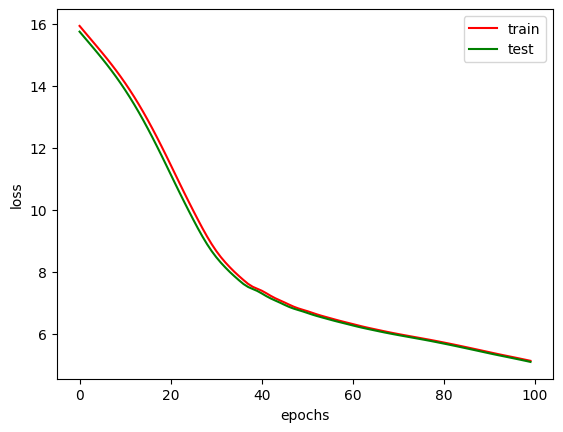

In [21]:
# plot data
fig, ax = plt.subplots(1, 1)
x = np.arange(0, epochs)
ax.plot(x, train_losses, label='train', color='red')
ax.plot(x, test_losses, label='test', color='green')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
plt.legend()
plt.show()


IndexError: list index out of range

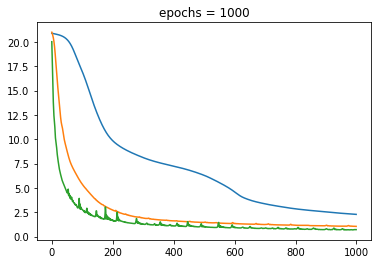

In [52]:
# plot size/performance comparison
fig, ax = plt.subplots(1, 1)

x = width_list
ax.set_title("epochs = 1000")
for i, w in enumerate(x):
    ax.plot(np.arange(0, epochs), test_results[i], label=w)
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
plt.show()